# TaxBlock demonstration

Jake Kara  
Final project  
Bitcoin and Blockchain, CSCI E-118  
Fall 2018


# Load solidity contracts

The solidity contracts that comprise TaxBlock are in the folder taxblock_solidity/

This script compiles them all together and creates an interface which we can use to instantiate individual contracts.

The _test_contracts_ module calls in python wrappers from the taxblock/ folder, which contains helpful wrappers of some of the common ethereum functions we learned in class. This abstraction allows for a simpler notebook.

In [1]:
from test_contracts import source, interface

Loading contract 'Named'
Loading contract 'Owned'
Loading contract 'Authorized'
Loading contract 'TaxAuthority'
Loading contract 'Taxed'
Loading contract 'Traded'
Loading contract 'Property'
Loading contract 'TaxBill'
Loading contract 'Authorized'
Loading contract 'Offer'

Compiling...
Success!


In [2]:
print ("There are %d accounts. Let's assign them:" % len(interface.w3.eth.accounts))

users = ["me","joe","bob","steve","bill","alice","jane","kathy","sarah","iris"]

universe = {
}

for i in range(len(users)):
    universe[users[i]] = interface.w3.eth.accounts[i]    

get_address = lambda x: universe[x]

def get_user(x): 
    
    for k in universe.keys():
        if universe[k] == x:
            return k
        
def print_universe():
    for user in universe.keys():
        user_addr = get_address(user)

        assert get_user(user_addr) == user
        is_default = ""
        if user_addr == interface.w3.eth.defaultAccount:
            is_default = "default: "
        print ("    %s %s" % (user_addr, is_default + user))
        
print_universe()


There are 10 accounts. Let's assign them:
    0x7E5F4552091A69125d5DfCb7b8C2659029395Bdf default: me
    0x2B5AD5c4795c026514f8317c7a215E218DcCD6cF joe
    0x6813Eb9362372EEF6200f3b1dbC3f819671cBA69 bob
    0x1efF47bc3a10a45D4B230B5d10E37751FE6AA718 steve
    0xe1AB8145F7E55DC933d51a18c793F901A3A0b276 bill
    0xE57bFE9F44b819898F47BF37E5AF72a0783e1141 alice
    0xd41c057fd1c78805AAC12B0A94a405c0461A6FBb jane
    0xF1F6619B38A98d6De0800F1DefC0a6399eB6d30C kathy
    0xF7Edc8FA1eCc32967F827C9043FcAe6ba73afA5c sarah
    0x4CCeBa2d7D2B4fdcE4304d3e09a1fea9fbEb1528 iris


# 1. Creating a tax authority

Anyone can create a tax authority by instantiating a TaxAuthority contract. We will call our town Bethel.

In [54]:
# Create a tax authority called bethel
bethel = interface.instance(
    name="TaxAuthority",
    constructor_args=["Bethel".encode()]
)

universe["bethel tax authority"] = bethel.address

In [55]:
get_address("bethel tax authority")

'0xD24260C102B5D128cbEFA0F655E5be3c2370677C'

In [56]:
get_user(get_address("bethel tax authority"))

'bethel tax authority'

In [57]:
# Convert bytes to strings and drop the remaining null characters
bytes2str = lambda b: b.decode("utf-8").rstrip('\x00')

# Print an underlined string
def underline(msg, char="="):
    msg_len = len(msg)
    print (msg)
    print (char * msg_len)
    
def summarize(tax_auth):
    underline ("TaxBlock summary for the town of %s" 
               % bytes2str(tax_auth.functions.name().call()))
    
    print("* The contract address is %s" % tax_auth.address)    
    print("* The owner is %s" % get_user(tax_auth.functions.owner().call())) 
    print("* The tax for transferring properties is $%d per $1000 of assessed value." % (
        tax_auth.functions.transferTaxRate().call()
    ))
    print("* Properties cannot be sold for %d permille more than their assessed value." % (
        tax_auth.functions.auditThreshold().call()
    ))
    print("* %s has issued %d tax bills." % (
        bytes2str(tax_auth.functions.name().call()),
        tax_auth.functions.taxBillCount().call()
    ))
    
summarize(bethel)

TaxBlock summary for the town of Bethel
* The contract address is 0xD24260C102B5D128cbEFA0F655E5be3c2370677C
* The owner is me
* The tax for transferring properties is $0 per $1000 of assessed value.
* Properties cannot be sold for 0 permille more than their assessed value.
* Bethel has issued 0 tax bills.


In [58]:
# Let's set the audit threshold and the transfer tax rate

# - The audit threshold is used to compute the maximum allowed sale price, 
#   based on the assessed value. It is in milles of assessed value
# - The transfer tax rate is the per mille amount charged on the sale price
#   of each transaction

bethel.functions.setAuditThreshold(500).transact()
bethel.functions.setTransferTaxRate(10).transact()
summarize(bethel)

TaxBlock summary for the town of Bethel
* The contract address is 0xD24260C102B5D128cbEFA0F655E5be3c2370677C
* The owner is me
* The tax for transferring properties is $10 per $1000 of assessed value.
* Properties cannot be sold for 500 permille more than their assessed value.
* Bethel has issued 0 tax bills.



This is the un-forgable contract address of the Bethel tax authority


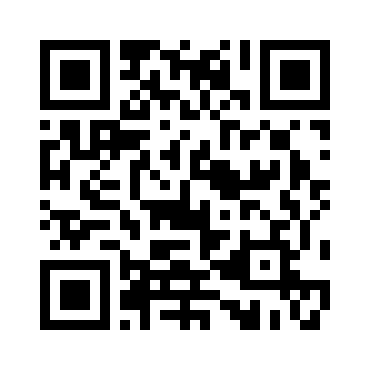

In [59]:
# Let's make a QR code we can share with property owners. 
# We can post it on the wall at town hall to make sure that
# they don't interact with fraudulent tax authorities.
!pip install qrcode
import qrcode

def print_qr_code(tax_auth):
    print ("")
    print ("This is the un-forgable contract address of the %s tax authority"
          % bytes2str(tax_auth.functions.name().call()))
    return qrcode.make(tax_auth.address)

print_qr_code(bethel)

# 2. Creating properties

Now that we have set up the taxauthority contract and posted the QR code on the wall, we are ready for business in the town clerk's office.

When someone comes in, we need to be able to make a property for them that is controlled by our tax authority contract.

Oh look, Bob, who owns four properties on Greenwood Avenue, has walked in the door. After a quick check of his paper records, we can see that he's all paid up and we're ready to create his properties in the taxblock system.

In [60]:
# Now let's make some properties
def make_property(tax_auth, property_name):
    tax_auth.functions.createProperty(property_name.encode()).transact()

# Make the properties that bob owns.
make_property(bethel, "1 Greenwood Avenue")
make_property(bethel, "2 Greenwood Avenue")
make_property(bethel, "3 Greenwood Avenue")
make_property(bethel, "4 Greenwood Avenue")

In [108]:
# NOTE: We cannot create a duplicate named property. This IS SUPPOSED TO FAIL
make_property(bethel, "1 Greenwood Avenue")

TransactionFailed: 

In [61]:
# Get a property
def get_property(tax_auth, property_name):
    return interface.instance_at_address(
        name="Property",
        address=tax_auth.functions.getPropertyByName(
            property_name.encode()
        ).call()
)

greenwood_1 = get_property(bethel, "1 Greenwood Avenue")
greenwood_1

In [62]:
def who_owns(ownable):
    
    # Any ownable will have an owner() function, a 
    # public getter() of the owner contract attribute
    
    owner_address = ownable.functions.owner().call()
    try:
        return get_user(owner_address)
    except:
        pass
    return owner_address

who_owns(bethel)

'me'

In [63]:
# Check who owns 1 Greenwood Avenue
who_owns(greenwood_1)

'bethel tax authority'

In [64]:
# Let's use the event log to get a list of properties
def read_log_entries(entity, event_type):
    ret = entity.events[event_type].createFilter(fromBlock=0).get_all_entries()
    return ret

def get_all_properties(tax_auth):
    ret = read_log_entries(tax_auth, "NewProperty")
    return [bytes2str(x["args"]["propertyName"]) for x in ret]

get_all_properties(bethel)


['1 Greenwood Avenue',
 '2 Greenwood Avenue',
 '3 Greenwood Avenue',
 '4 Greenwood Avenue']

In [65]:
def who_owns_every_property(tax_auth):
    for addr in get_all_properties(tax_auth):
        print ("%s: %s" % (addr, who_owns(get_property(bethel, addr))))
        
who_owns_every_property(bethel)

1 Greenwood Avenue: bethel tax authority
2 Greenwood Avenue: bethel tax authority
3 Greenwood Avenue: bethel tax authority
4 Greenwood Avenue: bethel tax authority


In [66]:
# Ok, let's finally change the owner of one
def transfer_property(tax_auth, prop, new_owner_address):
    tax_auth.functions.transferProperty(
        prop.functions.name().call(),
        new_owner_address
    ).transact()
    
transfer_property(bethel,
                  get_property(bethel, "1 Greenwood Avenue"),
                  get_address("bob"))

who_owns_every_property(bethel)

1 Greenwood Avenue: bob
2 Greenwood Avenue: bethel tax authority
3 Greenwood Avenue: bethel tax authority
4 Greenwood Avenue: bethel tax authority


In [67]:
# Woohoo! Let's do the rest
bethel.functions.transferProperty("2 Greenwood Avenue".encode(),
                                 get_address("bob")).transact()
bethel.functions.transferProperty("3 Greenwood Avenue".encode(),
                                 get_address("bob")).transact()
bethel.functions.transferProperty("4 Greenwood Avenue".encode(),
                                 get_address("bob")).transact()
who_owns_every_property(bethel)

1 Greenwood Avenue: bob
2 Greenwood Avenue: bob
3 Greenwood Avenue: bob
4 Greenwood Avenue: bob


In [71]:
def reposses_property(tax_auth, prop):
    transfer_property(
        tax_auth, 
        prop, 
        tax_auth.address
    )
reposses_property(bethel, get_property(bethel, "1 Greenwood Avenue"))
who_owns_every_property(bethel)

1 Greenwood Avenue: bethel tax authority
2 Greenwood Avenue: bob
3 Greenwood Avenue: bob
4 Greenwood Avenue: bob


# Check if properties are paid up

In [72]:
greenwood_1.functions.billIndex().call()

0

In [73]:
bethel.functions.taxBillCount().call()

0

In [74]:
greenwood_1.functions.isPaidCurrent().call()

True

# 3. Issuing tax bills

In [76]:
def create_tax_bill(tax_auth, tax_rate):
    
    """ tax_rate must be a per-mille amount, per 1000, 
    instead of percent which is per 100 """
    
    tax_auth.functions.createTaxBill(tax_rate).transact()

create_tax_bill(bethel, 30)
bethel.functions.taxBillCount().call()

1

In [78]:
# See that a new tax bill event was created
read_log_entries(bethel, "NewTaxBill")

[AttributeDict({'args': AttributeDict({'taxBillIndex': 0}),
  'event': 'NewTaxBill',
  'logIndex': 0,
  'transactionIndex': 0,
  'transactionHash': HexBytes('0x465d44aef0df8e020408daf390ebe2b146672bf0f02890966a542cbbd41e4263'),
  'address': '0xD24260C102B5D128cbEFA0F655E5be3c2370677C',
  'blockHash': HexBytes('0x709ab3a93dbe2391d9678641b82005b4ace6c763cd01573cba5088e09db6b3b1'),
  'blockNumber': 26})]

In [115]:
def get_tax_bill(tax_auth, i):
    return interface.instance_at_address(
        "TaxBill",
        tax_auth.functions.taxBills(i).call()
    )

print ("Property owes... %d " % get_tax_bill(bethel, 0).functions.amountDue(greenwood_1.address).call())

Property owes... 0 


# 4. Paying taxes

Now that a tax bill has been issued, let's see if our properties are still paid current

In [93]:
# Is Greenwood 1 still paid current?
get_property(bethel, "1 Greenwood Avenue").functions.isPaidCurrent().call()

True

### Let's see how much the owner owes

In [117]:
def property_summary(tax_auth, property_name):
    
    prop = get_property(tax_auth, property_name)
    
    underline("Summary for %s in %s" % (
        property_name,
        bytes2str(tax_auth.functions.name().call()),
    ))
    
    assessed_value = prop.functions.assessedValue().call()
   
    print ("* Owner is %s" % who_owns(prop))
    print ("* Assessed value is %d" % assessed_value)
    print ("* The maximum sale price is %d" % 
           tax_auth.functions.maximumSalePrice(assessed_value).call())
    print ("* The tax authority has issued %d tax bills" % tax_auth.functions.taxBillCount().call())
    print ("* The property has paid %d tax bills" % prop.functions.billIndex().call())
    is_paid = "is not"
    
    if prop.functions.isPaidCurrent().call():
        is_paid = "is"
    else:
        print (
        "* Here's the next outstanding bill: %d" % 
               get_tax_bill(
                   tax_auth, 
               props.functions.billIndex().call()
           ).functions.amountDue(prop.address)
          )

    print ("* The property %s paid current" % is_paid)
    
property_summary(bethel, "1 Greenwood Avenue")


Summary for 1 Greenwood Avenue in Bethel
* Owner is bethel tax authority
* Assessed value is 1000000
* The maximum sale price is 1500000
* The tax authority has issued 1 tax bills
* The property has paid 1 tax bills
* The property is paid current


In [104]:
greenwood_1.functions.isPaidCurrent

150

###  Nothing? That's because the property has no value...

Let's make it a $1 million property.

In [91]:
def set_assessed_value(tax_auth, prop, new_value):
    return tax_auth.functions.setPropertyAssessedValue(
        prop.address, 1000 * 1000
    ).transact() 

set_assessed_value(bethel,
                   greenwood_1,
                   1000 * 1000)


HexBytes('0x6abf01a618ded621512b044291c691c10ffbef8b96cf30a865bce7ede462578e')

... remember, tax rates are permille, not percent, so they are $30 per $1,000 in value, or:

In [92]:
print ("Property owes... %d " % tax_bill.functions.amountDue(greenwood_1.address).call())

Property owes... 0 


In [118]:
# Pay the taxes

def pay_next_bill(tax_auth, property):
    tax_auth.functions.payBill(prop.address).transact({
        "value":tax_bill.functions.amountDue(prop.address).call(),
    })
    


IndentationError: unexpected indent (<ipython-input-118-702ce0d6d20e>, line 4)

In [86]:
greenwood_1.functions.billIndex().call()

1

In [87]:
read_log_entries(bethel, "BillPaid")

[AttributeDict({'args': AttributeDict({'status': 2}),
  'event': 'BillPaid',
  'logIndex': 0,
  'transactionIndex': 0,
  'transactionHash': HexBytes('0xc2ef2b98c472bf5d7a7c8f2786a372edd7c0be3d23168bd0d9497af34de5b199'),
  'address': '0xD24260C102B5D128cbEFA0F655E5be3c2370677C',
  'blockHash': HexBytes('0x28b5dd11cceef11438076bea0f54994bb6930804c3f7cb1246bea86687f7b945'),
  'blockNumber': 29})]

In [88]:
tax_bill.functions.totalReceipts().call()

30000

In [89]:
greenwood_1.functions.isPaidCurrent().call()

True

In [30]:
tax_bill.functions.amountDue(greenwood_1.address).call()

0

In [31]:
for acc in interface.w3.eth.accounts:
     print ("%s\t%s" % (acc, interface.w3.eth.getBalance(acc)) )

0x7E5F4552091A69125d5DfCb7b8C2659029395Bdf	999999999999999993805282
0x2B5AD5c4795c026514f8317c7a215E218DcCD6cF	1000000000000000000000000
0x6813Eb9362372EEF6200f3b1dbC3f819671cBA69	1000000000000000000000000
0x1efF47bc3a10a45D4B230B5d10E37751FE6AA718	1000000000000000000000000
0xe1AB8145F7E55DC933d51a18c793F901A3A0b276	1000000000000000000000000
0xE57bFE9F44b819898F47BF37E5AF72a0783e1141	1000000000000000000000000
0xd41c057fd1c78805AAC12B0A94a405c0461A6FBb	1000000000000000000000000
0xF1F6619B38A98d6De0800F1DefC0a6399eB6d30C	1000000000000000000000000
0xF7Edc8FA1eCc32967F827C9043FcAe6ba73afA5c	1000000000000000000000000
0x4CCeBa2d7D2B4fdcE4304d3e09a1fea9fbEb1528	1000000000000000000000000


In [32]:
import random 

def create_random_address(w3):
    
    """ Borrowed this function from lecture """
    
    random_num =random.randrange(10 ** 80)
    hexi = "%064x" % random_num
    
    return w3.toChecksumAddress('0x' + hexi[:40])

bob = create_random_address(interface.w3)
bob

'0xdb65462AbE49EBCE6DE2c8229Bf23C2c590B60E7'

# Now let's try selling a property

Remeber the rules:

1. A property with back taxes cannot be sold
2. A  property cannot be sold for a lot more than* its assessed value

"A lot more" is defined as:

property.assessedValue + (tax_authority.auditTreshold / 1000) * property.assessedValue

In [33]:
def get_balance(entity):
    return interface.w3.eth.getBalance(entity.address)
get_balance(bethel)

30000

In [34]:
def create_random_funded_account(w3, amount=1000 * 1000 * 1000):
    
    addr = create_random_address(w3)
    
    w3.eth.sendTransaction({
        "to":addr,
        "from":interface.w3.eth.accounts[2],
        "value":amount
    })
    
    w3.eth.accounts.append(addr)
    
    return addr

bob = create_random_funded_account(interface.w3)

interface.w3.eth.getBalance(bob)

1000000000

In [35]:
[(acc, interface.w3.eth.getBalance(acc)) for acc in interface.w3.eth.accounts]

[('0x7E5F4552091A69125d5DfCb7b8C2659029395Bdf', 999999999999999993805282),
 ('0x2B5AD5c4795c026514f8317c7a215E218DcCD6cF', 1000000000000000000000000),
 ('0x6813Eb9362372EEF6200f3b1dbC3f819671cBA69', 999999999999998999979000),
 ('0x1efF47bc3a10a45D4B230B5d10E37751FE6AA718', 1000000000000000000000000),
 ('0xe1AB8145F7E55DC933d51a18c793F901A3A0b276', 1000000000000000000000000),
 ('0xE57bFE9F44b819898F47BF37E5AF72a0783e1141', 1000000000000000000000000),
 ('0xd41c057fd1c78805AAC12B0A94a405c0461A6FBb', 1000000000000000000000000),
 ('0xF1F6619B38A98d6De0800F1DefC0a6399eB6d30C', 1000000000000000000000000),
 ('0xF7Edc8FA1eCc32967F827C9043FcAe6ba73afA5c', 1000000000000000000000000),
 ('0x4CCeBa2d7D2B4fdcE4304d3e09a1fea9fbEb1528', 1000000000000000000000000)]

In [36]:
me = interface.w3.eth.accounts[0]

In [37]:
greenwood_1.functions.owner().call()

'0xF2E246BB76DF876Cef8b38ae84130F4F55De395b'

In [38]:
bethel.address

'0xF2E246BB76DF876Cef8b38ae84130F4F55De395b'

In [39]:
joe = interface.w3.eth.accounts[5]
transfer_property(bethel, greenwood_1, joe)

In [40]:
greenwood_1.functions.owner().call()

'0xE57bFE9F44b819898F47BF37E5AF72a0783e1141'

In [41]:
joe

'0xE57bFE9F44b819898F47BF37E5AF72a0783e1141'

In [42]:
offer = interface.instance(
    name="Offer",
    constructor_args=[greenwood_1.address],
    value = 1 + 1000 * 1000
)

In [43]:
# Submit the offer
greenwood_1.functions.makeOffer(offer.address).transact({"from":joe})

HexBytes('0x533816ae299aa4478711d9589396c8fb2d07750567e06102f61b10182cf7db32')

In [44]:
read_log_entries(greenwood_1, "NewOffer")

[AttributeDict({'args': AttributeDict({'offerIndex': 0}),
  'event': 'NewOffer',
  'logIndex': 0,
  'transactionIndex': 0,
  'transactionHash': HexBytes('0x533816ae299aa4478711d9589396c8fb2d07750567e06102f61b10182cf7db32'),
  'address': '0x4F9DA333DCf4E5A53772791B95c161B2FC041859',
  'blockHash': HexBytes('0x9b61311cf7164a12c8e7a300d9a6968e8791af09c6c6b622c7d1c97ab91b7304'),
  'blockNumber': 16})]

In [45]:
# Let's make sure the offer is funded
interface.w3.eth.getBalance(offer.address)

1000001

In [46]:
# Make sure joe owns it
greenwood_1.functions.owner().call() == joe

True

In [47]:
# Who wants to buy it?
offer.functions.buyer().call() == me

True

In [48]:
interface.w3.eth.getBalance(joe)

999999999999999999914816

In [49]:
offer.functions.accept().transact({"from":joe})

HexBytes('0x1001f4713016900a532e68691c8ea8662f17e8a26f632043379fc00e756629aa')

In [50]:
interface.w3.eth.getBalance(joe)

1000000000000000000838909

In [51]:
# Now let's see who owns it
greenwood_1.functions.owner().call() == me

True

In [59]:
print ("The most I can sell the property for is: %s" 
       % bethel.functions.maximumSalePrice(greenwood_1.functions.assessedValue().call()).call())

The most I can sell the property for is: 1500000
